In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [10]:
dir_path = '../cnn/10_food_classes_all_data'
train_path = os.path.join(dir_path, 'train')
test_path = os.path.join(dir_path, 'test')

## Preprocessing

In [16]:
IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_path, label_mode='categorical', image_size=IMG_SIZE )
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_path, label_mode='categorical', image_size=IMG_SIZE , shuffle=False)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Train with transfer learning

In [19]:
# create model checkpoint
check_point_path = 'model-food-checkpoint'
check_point = tf.keras.callbacks.ModelCheckpoint(check_point_path, save_best_only=True, save_weights_only=True, monitor='val_accuracy')

In [24]:
# create data augmentation
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

#setup data augmentation
data_augmentation = Sequential([ 
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(.2),
    preprocessing.RandomHeight(.2),
    preprocessing.RandomWidth(.2),
    preprocessing.RandomZoom(.3),
    # preprocessing.Rescaling(1/255.) # efficient net has rescall build in
], name = 'data_augmentation')

In [30]:
#setup the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # cut out output 
base_model.trainable = False

inputs = layers.Input(shape=(224,224,3), name = 'input_layer')
x = data_augmentation(inputs)
x = base_model(x, training = False) # frozen base model weights
x = layers.GlobalAveragePooling2D(name='2D_global_avg_pool')(x) # pool in feature vector
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

model_1 = tf.keras.Model(inputs, outputs)

In [31]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, None)   0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 2D_global_avg_pool (GlobalA  (None, 1280)             0         
 veragePooling2D)                                                
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainabl

In [33]:
model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=['accuracy'])
hist_1 = model_1.fit(train_data.repeat() ,
                     steps_per_epoch= int(len(train_data) * .1), 
                     epochs=3, validation_data= test_data.repeat(), 
                     validation_steps = int(len(test_data) * .1), 
                     callbacks=[check_point])

Epoch 1/3
23/23 [==============================] - 43s 2s/step - loss: 1.9988 - accuracy: 0.3329 - val_loss: 1.7938 - val_accuracy: 0.3214
Epoch 2/3
23/23 [==============================] - 37s 2s/step - loss: 1.4628 - accuracy: 0.6318 - val_loss: 1.5308 - val_accuracy: 0.4509
Epoch 3/3
23/23 [==============================] - 35s 2s/step - loss: 1.2217 - accuracy: 0.6413 - val_loss: 1.0778 - val_accuracy: 0.6205


In [34]:
model_1.evaluate(test_data)

79/79 [==============================] - 90s 1s/step - loss: 0.9144 - accuracy: 0.7572


[0.9144201278686523, 0.7572000026702881]

### Fine Tuning

In [51]:
base_model.trainable = True
# Refreeze all layer expept the top 5 (close to output layer)
for layer in base_model.layers[:-5] :
    layer.trainable = False

In [52]:
for layer in base_model.layers[-10:] :
    print(layer.name, layer.trainable)

block7a_se_squeeze False
block7a_se_reshape False
block7a_se_reduce False
block7a_se_expand False
block7a_se_excite False
block7a_project_conv True
block7a_project_bn True
top_conv True
top_bn True
top_activation True


In [60]:
for layer in model_1.layers :
    print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
2D_global_avg_pool True
output_layer True


In [61]:
# recompile model with lower leraning rate
model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=.0001), 
                metrics=['accuracy'])

# continue training from previous trained
hist_2 = model_1.fit(train_data.repeat() ,
                     steps_per_epoch= int(len(train_data) * .3), 
                     epochs=6, validation_data= test_data.repeat(), 
                     validation_steps = int(len(test_data) * .1),
                     initial_epoch = hist_1.epoch[-1], 
                     callbacks=[check_point])

Epoch 3/6
70/70 [==============================] - 100s 1s/step - loss: 0.9062 - accuracy: 0.7250 - val_loss: 0.7029 - val_accuracy: 0.7634
Epoch 4/6
70/70 [==============================] - 97s 1s/step - loss: 0.8297 - accuracy: 0.7353 - val_loss: 0.5638 - val_accuracy: 0.8036
Epoch 5/6
70/70 [==============================] - 100s 1s/step - loss: 0.7612 - accuracy: 0.7567 - val_loss: 0.7523 - val_accuracy: 0.7366
Epoch 6/6
70/70 [==============================] - 114s 2s/step - loss: 0.6549 - accuracy: 0.7838 - val_loss: 0.5849 - val_accuracy: 0.8170


In [62]:
model_1.evaluate(test_data)

79/79 [==============================] - 98s 1s/step - loss: 0.4405 - accuracy: 0.8560


[0.4405106008052826, 0.8560000061988831]

> ok, our model perform better after fine tuning

Continue train and train more layers

In [74]:
# train the model with more layers
for layer in base_model.layers[-10:] :
    layer.trainable = True

In [76]:
for layer in base_model.layers[-15:] :
    print(layer.name, layer.trainable)

block7a_expand_bn False
block7a_expand_activation False
block7a_dwconv False
block7a_bn False
block7a_activation False
block7a_se_squeeze True
block7a_se_reshape True
block7a_se_reduce True
block7a_se_expand True
block7a_se_excite True
block7a_project_conv True
block7a_project_bn True
top_conv True
top_bn True
top_activation True


In [79]:
for layer in model_1.layers[2].layers[-15:]:
    print(layer.name, layer.trainable)


block7a_expand_bn False
block7a_expand_activation False
block7a_dwconv False
block7a_bn False
block7a_activation False
block7a_se_squeeze True
block7a_se_reshape True
block7a_se_reduce True
block7a_se_expand True
block7a_se_excite True
block7a_project_conv True
block7a_project_bn True
top_conv True
top_bn True
top_activation True


In [82]:
# recompile model with lower leraning rate
model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=.00005), 
                metrics=['accuracy'])

# continue training from previous trained
hist_3 = model_1.fit(train_data.repeat() ,
                     steps_per_epoch= int(len(train_data) * .5), 
                     epochs=8, validation_data= test_data.repeat(), 
                     validation_steps = int(len(test_data) * .1),
                     initial_epoch = hist_2.epoch[-1], 
                     callbacks=[check_point])

Epoch 6/8
117/117 [==============================] - 165s 1s/step - loss: 0.6201 - accuracy: 0.7967 - val_loss: 0.4992 - val_accuracy: 0.8259
Epoch 7/8
117/117 [==============================] - 163s 1s/step - loss: 0.6314 - accuracy: 0.7901 - val_loss: 0.4939 - val_accuracy: 0.8214
Epoch 8/8
117/117 [==============================] - 173s 1s/step - loss: 0.5686 - accuracy: 0.8153 - val_loss: 0.4201 - val_accuracy: 0.8571


In [83]:
model_1.evaluate(test_data)

79/79 [==============================] - 89s 1s/step - loss: 0.3960 - accuracy: 0.8672


[0.39598798751831055, 0.8672000169754028]

> ok, it's perform better !!

but if it perform worse

In [84]:
#load weight from best pass model trained
# model_1.load_weights(check_point_path)

## Make Predictions

In [ ]:
predict_proba = model_1.predict(test_data)

In [258]:
print(predict_proba.shape, predict_proba[0].shape,"\n", predict_proba[0])

(2500, 10) (10,) 
 [9.3739444e-01 3.5615684e-03 1.4328933e-04 3.1678514e-03 2.0386147e-05
 1.9442694e-05 4.6766421e-05 3.8357124e-02 1.7056387e-02 2.3274573e-04]


In [93]:
predict_labels = np.argmax(predict_proba, axis=1)
predict_labels[:5] # order labels because we didn't shuffle

array([0, 0, 0, 0, 0], dtype=int64)

In [151]:
class_names = train_data.class_names
class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [152]:
top_3_index = [np.argsort(predict_proba[0])[-3:][::-1]]
top_3_confident = predict_proba[0][tuple(top_3_index)]
print(top_3_confident)
print(np.array(class_names)[tuple(top_3_index)])

[0.93739444 0.03835712 0.01705639]
['chicken_curry' 'ramen' 'steak']


### Create helper function

In [350]:
def crate_top_confident(predict_proba,n_top = 3):
    '''
    return top index and top confident
    '''

    top_index = list(np.argsort(predict_proba, axis=1)[:,-n_top:][:,::-1])
    top_confident = []
    for i, row in enumerate(top_index) :
        top_confident.append(predict_proba[i,tuple(row)])
    return top_index, np.array(top_confident)

In [351]:
top_index, top_confident = crate_top_confident(predict_proba, 3)
len(top_index), top_confident.shape

(2500, (2500, 3))

In [343]:
# unbatch data set
def unbatch_data(data_batch, n_class, has_labels=True):
   '''
   unbatch data and seperate images and labels (if has_labels)
   '''    
   _images = []
   _labels = []

   if has_labels :
      for images, labels in data_batch.unbatch():
         _images.append(images)
         if n_class > 2:
            _labels.append(np.argmax(labels))
         else :
            _labels.append(np.round(labels))
      
      return np.array(_images), np.array(_labels)

   for images in data_batch.unbatch():
      _images.append(images)
      
   return np.array(_images)

In [344]:
images, labels = unbatch_data(test_data,10)
images.shape, labels.shape

((2500, 224, 224, 3), (2500,))

In [345]:
def load_image_from_path(filepath, resize=[224,224],scale=False, channel=3):
    '''
    load images from path to tensorflow array and resize
    scale : if True rescale to [0..1]
    chennel : channel of image
    '''
    img = tf.io.read_file(filepath)
    img = tf.io.decode_image(img, channels=channel)
    img = tf.image.resize(img, size=resize)

    if scale :
        return img/255.
    
    return img

In [663]:
def plot_top_prediction(true_images :np, predict_proba, true_labels=None, n_top = 3 ,n_images = 3, has_labels=True):
    '''
    plot random images by top prediction confident from predict_proba 
    has_labels = False , for presict on custom images
    '''

    import random
    top_index, top_confident = crate_top_confident(predict_proba, n_top=n_top)
      
    for i in range(1,n_images+1):
        if has_labels :
            index = random.randint(0,len(true_images)-1)
        else:
            index = i-1
        # plot confident
        plt.figure(figsize=(15,5*n_images))
        plt.subplot(n_images,2,1)
        plt.title(f'Top {n_top} Predictions')
        plt.xlabel('confident')
        graph = np.array(class_names)[tuple([top_index[index]])][::-1] # re order
        top_plot = plt.barh(graph, width=top_confident[index][::-1], color='gray')

        if has_labels :
            #color of true label
            if np.isin(labels[index], top_index[index]):
                top_plot[np.argmax(top_index[index][::-1] == labels[index])].set_color('green')


        #plot image
        plt.subplot(n_images,2,2)
        confident_percent = top_confident[index][0] * 100
        
        if has_labels :
            title = f'{confident_percent:.2f}% {class_names[ top_index[index][0] ]} / {class_names[ labels[index] ]}'

            color = 'blue' if top_index[index][0] == labels[index] else 'red'
        else :
            title = f'{confident_percent:.2f}% {class_names[ top_index[index][0] ]}'
            color = 'black'

        plt.title(title,color=color)

        if true_images[index].max() > 1 : # rescall
            img = true_images[index]/255.
            plt.imshow(img)
        else :
            plt.imshow(true_images[index])
        plt.axis('off')

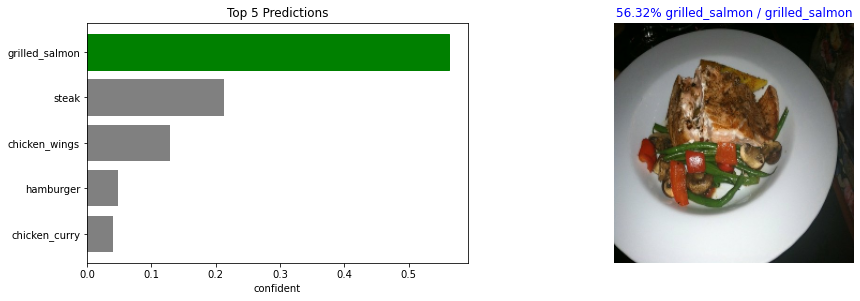

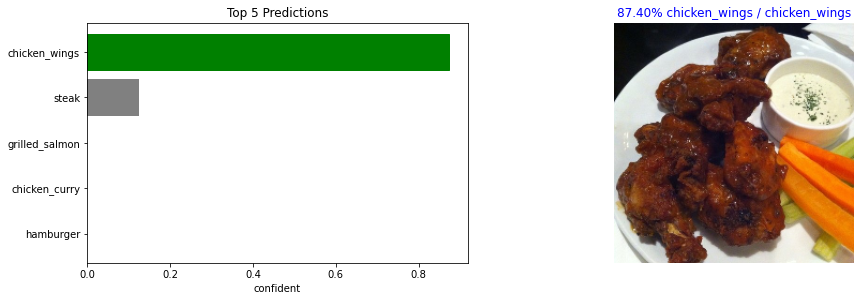

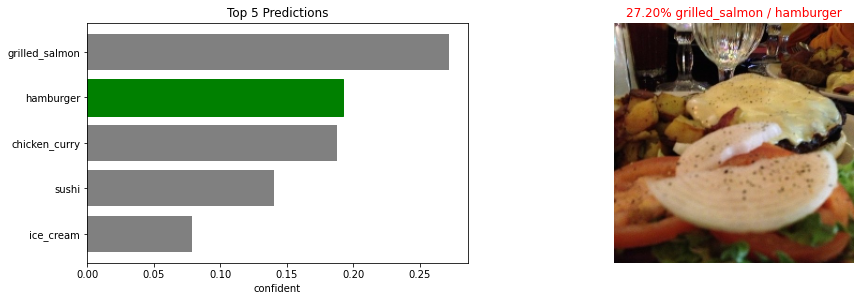

In [672]:
plot_top_prediction(images, predict_proba, labels,n_top=5, n_images=3)

## Find the most wrong Predictions

In [536]:
file_path = []
for filepath in test_data.list_files('../cnn/10_food_classes_all_data/test/*/*.jpg', shuffle=False) : # all class all image
    file_path.append(filepath.numpy())
file_path[:3]

[b'..\\cnn\\10_food_classes_all_data\\test\\chicken_curry\\101833.jpg',
 b'..\\cnn\\10_food_classes_all_data\\test\\chicken_curry\\10340.jpg',
 b'..\\cnn\\10_food_classes_all_data\\test\\chicken_curry\\1035626.jpg']

In [553]:
import pandas as pd
pred_df = pd.DataFrame({'img_path':file_path,
                         'y_true':labels,
                         'y_preds':predict_labels,
                         'confident':top_confident[:,0],
                         'y_true_classname':[class_names[i] for i in labels],
                         'y_preds_classname':[class_names[i] for i in predict_labels]})

In [556]:
# find whick prediction are wrong
pred_df['pred_correct'] = pred_df['y_true'] ==  pred_df['y_preds'] 
pred_df.sample(5)

,img_path,y_true,y_preds,confident,y_true_classname,y_preds_classname,pred_correct
2306,b'..\\cnn\\10_food_classes_all_data\\test\\sus...,9,9,0.985441,sushi,sushi,True
1489,b'..\\cnn\\10_food_classes_all_data\\test\\ice...,5,5,0.913557,ice_cream,ice_cream,True
1667,b'..\\cnn\\10_food_classes_all_data\\test\\piz...,6,6,0.999872,pizza,pizza,True
835,b'..\\cnn\\10_food_classes_all_data\\test\\gri...,3,8,0.638826,grilled_salmon,steak,False
2454,b'..\\cnn\\10_food_classes_all_data\\test\\sus...,9,9,0.974391,sushi,sushi,True


In [561]:
#sort dataframe most wrong predict at the top
top_10_wrong = pred_df[pred_df['pred_correct'] == False].sort_values('confident', ascending=False)[:10]
top_10_wrong

,img_path,y_true,y_preds,confident,y_true_classname,y_preds_classname,pred_correct
1602,b'..\\cnn\\10_food_classes_all_data\\test\\piz...,6,4,0.997521,pizza,hamburger,False
590,b'..\\cnn\\10_food_classes_all_data\\test\\fri...,2,0,0.989939,fried_rice,chicken_curry,False
824,b'..\\cnn\\10_food_classes_all_data\\test\\gri...,3,0,0.976915,grilled_salmon,chicken_curry,False
549,b'..\\cnn\\10_food_classes_all_data\\test\\fri...,2,0,0.960637,fried_rice,chicken_curry,False
362,b'..\\cnn\\10_food_classes_all_data\\test\\chi...,1,8,0.957330,chicken_wings,steak,False
914,b'..\\cnn\\10_food_classes_all_data\\test\\gri...,3,4,0.954203,grilled_salmon,hamburger,False
2162,b'..\\cnn\\10_food_classes_all_data\\test\\ste...,8,3,0.952328,steak,grilled_salmon,False
2467,b'..\\cnn\\10_food_classes_all_data\\test\\sus...,9,8,0.952011,sushi,steak,False
44,b'..\\cnn\\10_food_classes_all_data\\test\\chi...,0,2,0.950491,chicken_curry,fried_rice,False
520,b'..\\cnn\\10_food_classes_all_data\\test\\fri...,2,0,0.941248,fried_rice,chicken_curry,False


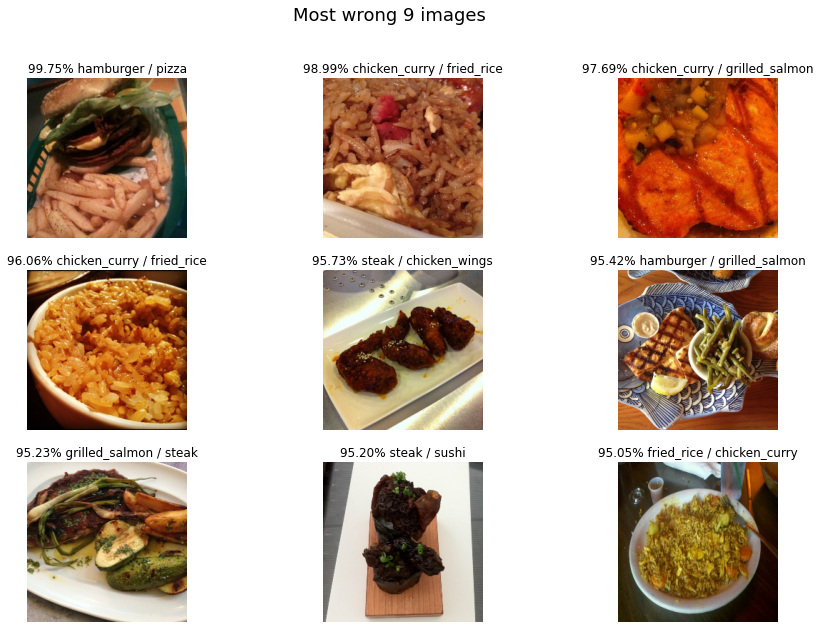

In [576]:
# visualize the most wrong images
images_to_view = 9
plt.figure(figsize=(15,10))
for i, row in enumerate(top_10_wrong[:images_to_view].itertuples()) :
    plt.subplot(3,3,i+1)
    img = load_image_from_path(row[1], scale=True) # row[1] retrun image path from datafram
    confident, y_true, y_pred = row[4]*100, row[5], row[6]
    plt.imshow(img)
    title = f'{confident:.2f}% {y_pred} / {y_true}'
    plt.title(title)
    plt.axis('off')
plt.suptitle(f'Most wrong {images_to_view} images', fontsize=18);

## Test on our images

In [645]:
test_imags_path = 'test-food'
custom_images = [load_image_from_path(os.path.join(test_imags_path,image_path)) for image_path in os.listdir(test_imags_path)]
custom_images = np.array(custom_images)

In [646]:
predict_custom_proba = model_1.predict(custom_images)

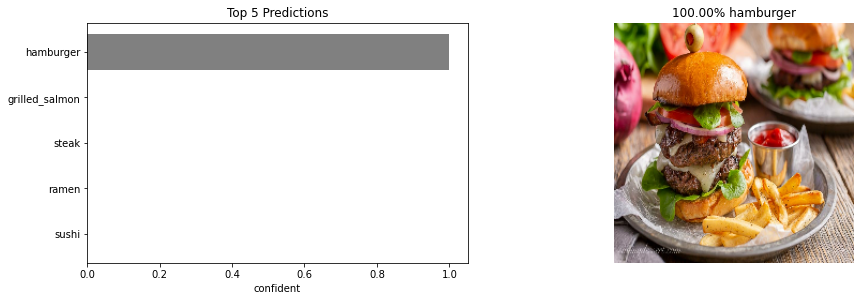

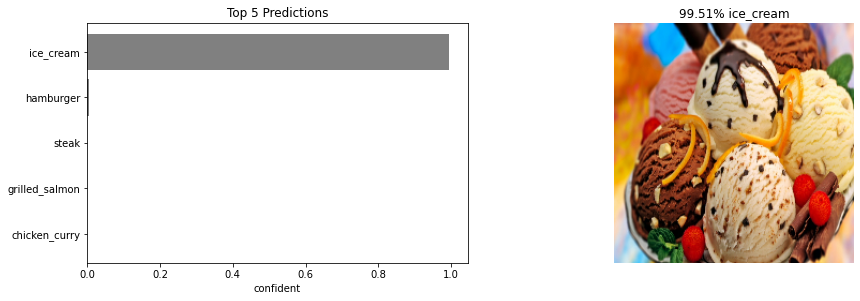

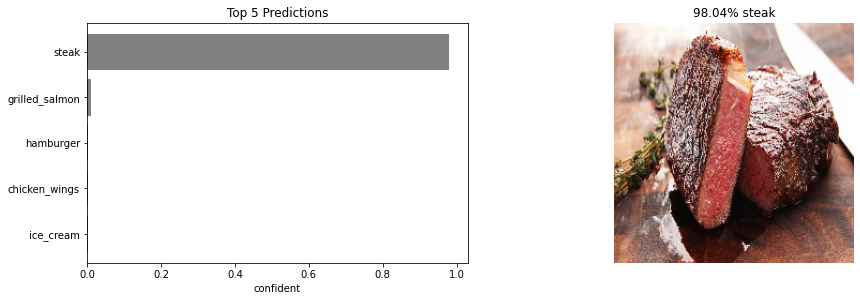

In [674]:
plot_top_prediction(custom_images, predict_custom_proba, n_top=5,has_labels=False)

> model perform actually good.

In [675]:
model_1.save('food-10-class-model.h5')